In [2]:
import numpy as np
import scipy.stats as ss
import sklearn
import sklearn.metrics
import sys
import tick.hawkes as hk
from bisect import bisect
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import scipy
from sklearn.linear_model import LogisticRegression
sys.path.append("../framework")
from aux_funcs import *
from pp_metrics import *

In [3]:
np.seterr(over = 'warn', under = 'warn')


def rankcorr(A_true, A_pred, pvalues = False): 
    assert len(A_true) == len(A_pred)

    ts = []
    for i in range(len(A_pred)):
        tau = ss.kendalltau(A_true[i], A_pred[i])
        t = tau[0]
        pvalue = tau[1]
        if not np.isnan(t):
            if (pvalues):
                ts.append(pvalue)
            else:
                ts.append(t)
    return ts

def frob_norm(A_true, A_pred):
    norm = []
    for i in range(A_true.shape[0]):
        diff = A_true[i] - A_pred[i]
        diff_norm = (np.sum(diff**2))**0.5
        norm.append(diff_norm)
    return norm

def precision(A_true, A_pred, k = 10):
    res = 0.0
    precisionl = []
    for i in range(A_true.shape[0]):
        k_not_0 = np.sum(A_true[0]>0)
        sorted_idx_pred = sorted(range(len(A_pred[i])), key=lambda x:A_pred[i][x], reverse=True)[:k_not_0]
        sorted_idx_true = sorted(range(len(A_true[i])), key=lambda x:A_true[i][x], reverse=True)[:k_not_0]
        precisionl.append(len(np.intersect1d(sorted_idx_pred,sorted_idx_true,assume_unique=True))/k_not_0) 
    return precisionl

def rel_err(A_true, A_pred):
    err = []
    for i in range(len(A_true)):
        denom = np.abs(np.where(A_true[i]==0,1,A_true[i]))
        v = np.sum(np.abs(A_true[i]-A_pred[i])/denom)
        err.append(v)
    return err

def rel_err_baseline(ground_truth, baselines):
    rel_err = 0
    err = []
    for i in range(len(baselines)):
        err.append(baselines[i]-ground_truth[i])**2
        rel_err+=(baselines[i]-ground_truth[i])**2
    rel_err= rel_err**0.5 / (sum([mu**2 for mu in ground_truth]))**0.5
    return rel_err

def ndcg_bin(A_true, A_pred):
    dcgp_avg = []
    for i in range(len(A_pred)):
        dcgp = 0
        idcgp = 0
        sorted_idx = sorted(range(len(A_pred[i])), key=lambda x:A_pred[i][x], reverse=True)
        gt_idx = 0
        for j in range(len(A_pred[i])):
            if A_true[i][sorted_idx[j]] != 0:
                dcgp += (1)/np.log2(j+2)
            if A_true[i][j] != 0:
                idcgp += (1)/np.log2(gt_idx+2)
                gt_idx +=1
        if(np.any(A_true[i])):
            dcgp_avg.append(dcgp/idcgp)
    assert len(dcgp_avg) > 0
    return dcgp_avg

def ndcg(A_true, A_pred):
    dcgp_avg = []
    for i in range(len(A_pred)):
        dcgp = 0
        idcgp = 0
        sorted_idx_true = sorted(range(len(A_true[i])), key=lambda x:A_true[i][x], reverse=True)
        sorted_idx_pred = sorted(range(len(A_pred[i])), key=lambda x:A_pred[i][x], reverse=True)
       
        p_sorted_by_pred = A_pred[i][sorted_idx_pred]
        reltrue = A_true[i][sorted_idx_true]
        #reltrue = reltrue[p_sorted_by_pred != 0]
        relpred = np.where(p_sorted_by_pred==0, 0, A_true[i][sorted_idx_pred])
        #relpred = relpred[p_sorted_by_pred != 0]
  
        n = len(A_pred[i])
        dcgp = np.sum((2**relpred - 1)/np.log2(np.arange(n)+2))
        idcgp = np.sum((2**reltrue - 1)/np.log2(np.arange(n)+2))
        all_zeros_true = np.all(A_true[i] == 0)
        all_zeros_pred = np.all(A_pred[i] == 0)
        if all_zeros_pred and all_zeros_true:
            dcgp_avg.append(1.)
        elif all_zeros_pred and not all_zeros_true:
            dcgp_avg.append(0.)
        elif not all_zeros_pred and not all_zeros_true:
            dcgp_avg.append(dcgp/idcgp)
            
    assert len(dcgp_avg) > 0
    return dcgp_avg

def ndcg2(A_true, A_pred):
    dcgp_avg = []
    for i in range(len(A_pred)):
        dcgp = 0
        idcgp = 0
        sorted_idx_true = sorted(range(len(A_true[i])), key=lambda x:A_true[i][x], reverse=True)
        sorted_idx_pred = sorted(range(len(A_pred[i])), key=lambda x:A_pred[i][x], reverse=True)
        gt_idx = 0
        for j in range(len(A_pred[i])):
            relpred = A_true[i][sorted_idx_pred[j]]
            reltrue = A_true[i][sorted_idx_true[j]]
            if A_pred[i][sorted_idx_pred[j]] > 0:
                dcgp += (2**relpred - 1)/np.log2(j+2)
            idcgp += (2**reltrue - 1)/np.log2(j+2)
        if(np.any(A_true[i])):
            dcgp_avg.append(dcgp/idcgp)
    assert len(dcgp_avg) > 0
    return dcgp_avg

def roc_auc(A_true, A_pred):
    binGT = A_true > 0
    true_values = binGT.flatten()
    y_values = A_pred.flatten()
    rocl = []
    for i in range(len(A_pred)):
        if np.any(binGT[i]):
            rocl.append(sklearn.metrics.roc_auc_score(binGT[i], A_pred[i]))
    return rocl

def nrmse(A_true, A_pred):
    err = []
    for i in range(len(A_true)):
        v = np.sum((A_true[i]-A_pred[i])**2)
        if(np.any(A_true[i])):
            v = ((1/len(A_true[i]))*v)**0.5/(max(A_true[i])-min(A_true[i]))
            err.append(v)
    assert len(err) > 0
    return err


def apbin(A_true, A_pred):
    map_avg = []
    binGT = A_true > 0.
    for i in range(len(A_pred)):
        ap = 0
        sorted_idx = sorted(range(len(A_pred[i])), key=lambda x:A_pred[i][x], reverse=True)
        num_correct = 0
        for k in range(1,len(A_pred[i])+1):
            if (binGT[i][sorted_idx[k-1]]) and (A_pred[i][sorted_idx[k-1]]):
                num_correct += 1
                ap += num_correct/k
        if np.any(binGT[i]):
            map_avg.append(ap/np.sum(binGT[i]))  
    return map_avg

def apk(A_true, A_pred):
    map_avg = []
    for i in range(len(A_pred)):
        idx_pred = np.arange(len(A_pred[i]))[A_pred[i]!=0]
        sorted_idx_pred = np.array(sorted(idx_pred, key=lambda x:A_pred[i][x], reverse=True))
        sorted_idx_true = np.array(sorted(range(len(A_true[i])), key=lambda x:A_true[i][x], reverse=True))
        pk = 0
        numTrue = np.sum(A_true[i]>0)
        for k in range(1,numTrue+1):
            pk += len(np.intersect1d(sorted_idx_pred[:k],sorted_idx_true[:k],assume_unique=True))/k  
        map_avg.append(pk/numTrue)  
    return map_avg

def spectrum_laplacian_ksdist(A_true, A_pred, low=True):
    sym_A_true = np.copy(A_true)
    sym_A_pred = np.copy(A_pred)

    i_triang = np.tril_indices(A_true.shape[0], 0)
    if low:
        sym_A_true.T[i_triang] = sym_A_true[i_triang]
        sym_A_pred.T[i_triang] = sym_A_pred[i_triang]
    else:
        sym_A_true[i_triang] = sym_A_true.T[i_triang]
        sym_A_pred[i_triang] = sym_A_pred.T[i_triang]
    L_true = scipy.sparse.csgraph.laplacian(sym_A_true)
    L_pred = scipy.sparse.csgraph.laplacian(sym_A_pred)

    eigen_true = np.linalg.eig(L_true)[0]
    eigen_pred = np.linalg.eig(L_pred)[0]
    
    return [ss.ks_2samp(eigen_true, eigen_pred)[0]]

def det_diff(A_true, A_pred):
    diff = A_true - A_pred
    return [np.linalg.det(diff)]

def shuffle_rank(d):
    shuffled = np.array([np.arange(d) for i in range(d)])
    for row in range(d):
        np.random.shuffle(shuffled[row])
    return shuffled

def shuffle_matrix(gt):
    shuffled = np.copy(gt)
    for row in range(gt.shape[0]):
        shuffled[row] = np.random.permutation(shuffled[row])
    return shuffled



In [17]:
def calc_pvalues(metric, modelAPred, groundTruth, precisionK=None, n=1000):
    if metric == precision:
        orig_values = np.array(metric(groundTruth, modelAPred, k=precisionK))
    else:
        orig_values = np.array(metric(groundTruth, modelAPred))
    cnt_pvalue = np.zeros(orig_values.shape)
    #print(metric, np.mean(orig_values))
    for i in range(n):
        shuffled = shuffle_matrix(modelAPred)
        if metric == precision:
            shuf_values = np.array(metric(groundTruth, shuffle_matrix(modelAPred), k=precisionK))
        else:
            shuf_values = np.array(metric(groundTruth, shuffle_matrix(modelAPred)))
        if metric == rel_err or metric == nrmse or metric == frob_norm:
            cnt_pvalue += (shuf_values <= orig_values)
        else:
            cnt_pvalue += (shuf_values >= orig_values)
    return cnt_pvalue/n


file_list = ["CollegeMsg","sx-askubuntu", "sx-mathoverflow", "sx-superuser", "email-Eu-core-temporal", "wiki-talk-temporal","memetracker_2009-01"]

datapath = {}
for file in file_list:
    if file == "chalearn":
        datapath[file] = ("../data/"+file+"/"+file+"_ticks.dat","../data/"+file+"/"+file+"_groundtruth.npy")
    elif file == "memetracker_2009-01":
        datapath[file] = ("../../../Desktop/datasets/"+file+"_ticks_topmonth.dat","../../../Desktop/datasets/"+file+"_groundtruth_topmonth.npy")
    else:
        datapath[file] = ("../data/"+file+"/"+file+"_ticks_topmonth.dat","../data/"+file+"/"+file+"_groundtruth_topmonth.npy")

models = ["HkEM", "ADM4", "SG", "Cumulant", "Granger", "ExpKern"]


metric_names ={rankcorr: "RankCorr", precision: "P@n", rel_err: "RelErr", \
               ndcg_bin: "NDCGbin", ndcg: "NDCG", roc_auc: "ROCAUC", \
               nrmse: "NRMSE", apbin: "APbin", apk: "AP@n", spectrum_laplacian_ksdist :"Laplacian_Spec", \
               det_diff:"DetDiff", frob_norm:"FrobNorm"}
metrics = [rankcorr, rel_err, precision, apk, ndcg, roc_auc, nrmse]
#metrics = [frob_norm]

d = 0
entries_orig = []
for file in file_list:
    print("\n"+ file)
    
    timestamps, groundTruth = read_timestamps_groundtruth(datapath[file][0],datapath[file][1])

    precisionK = np.ceil(len(groundTruth)/10)
    md = 0
    for model in models:
        print(model)
        filepath = "../framework/results/"+file+"/"+model+"/"
        modelAPred = read_adjacency (filepath)
        if model != "Granger":
            modelAPred = modelAPred.T
        baseline = read_baselines(filepath)
        
        if file=="chalearn":
            metrics = [apbin, ndcg_bin, roc_auc]
        
        mt = 0
        for metric in metrics:
            #p_values = calc_pvalues(metric, modelAPred, groundTruth, precisionK = precisionK, n=1000)
            #print(metric_names[metric])
            if metric == rankcorr:
                p_values = rankcorr(groundTruth, modelAPred, pvalues = True)
            else:
                p_values = calc_pvalues(metric, modelAPred, groundTruth, precisionK = precisionK, n=1000)
            
            for p_value in p_values:
                entries_orig.append ([d,md,mt,p_value])
            mt += 1
        md += 1
    d += 1
    


CollegeMsg
HkEM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: underflow encountered in square


ADM4
SG
Cumulant
Granger
ExpKern

sx-askubuntu
HkEM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: underflow encountered in square


ADM4
SG
Cumulant
Granger
ExpKern

sx-mathoverflow
HkEM
ADM4
SG
Cumulant
Granger
ExpKern

sx-superuser
HkEM
ADM4
SG
Cumulant
Granger
ExpKern

email-Eu-core-temporal
HkEM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: underflow encountered in square


ADM4
SG
Cumulant
Granger
ExpKern

wiki-talk-temporal
HkEM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: underflow encountered in square


ADM4
SG
Cumulant
Granger
ExpKern

memetracker_2009-01
HkEM
ADM4
SG
Cumulant
Granger
ExpKern


0.5413654618473895
[(0, <function frob_norm at 0x7f06ed358d08>)]


IndexError: list index out of range

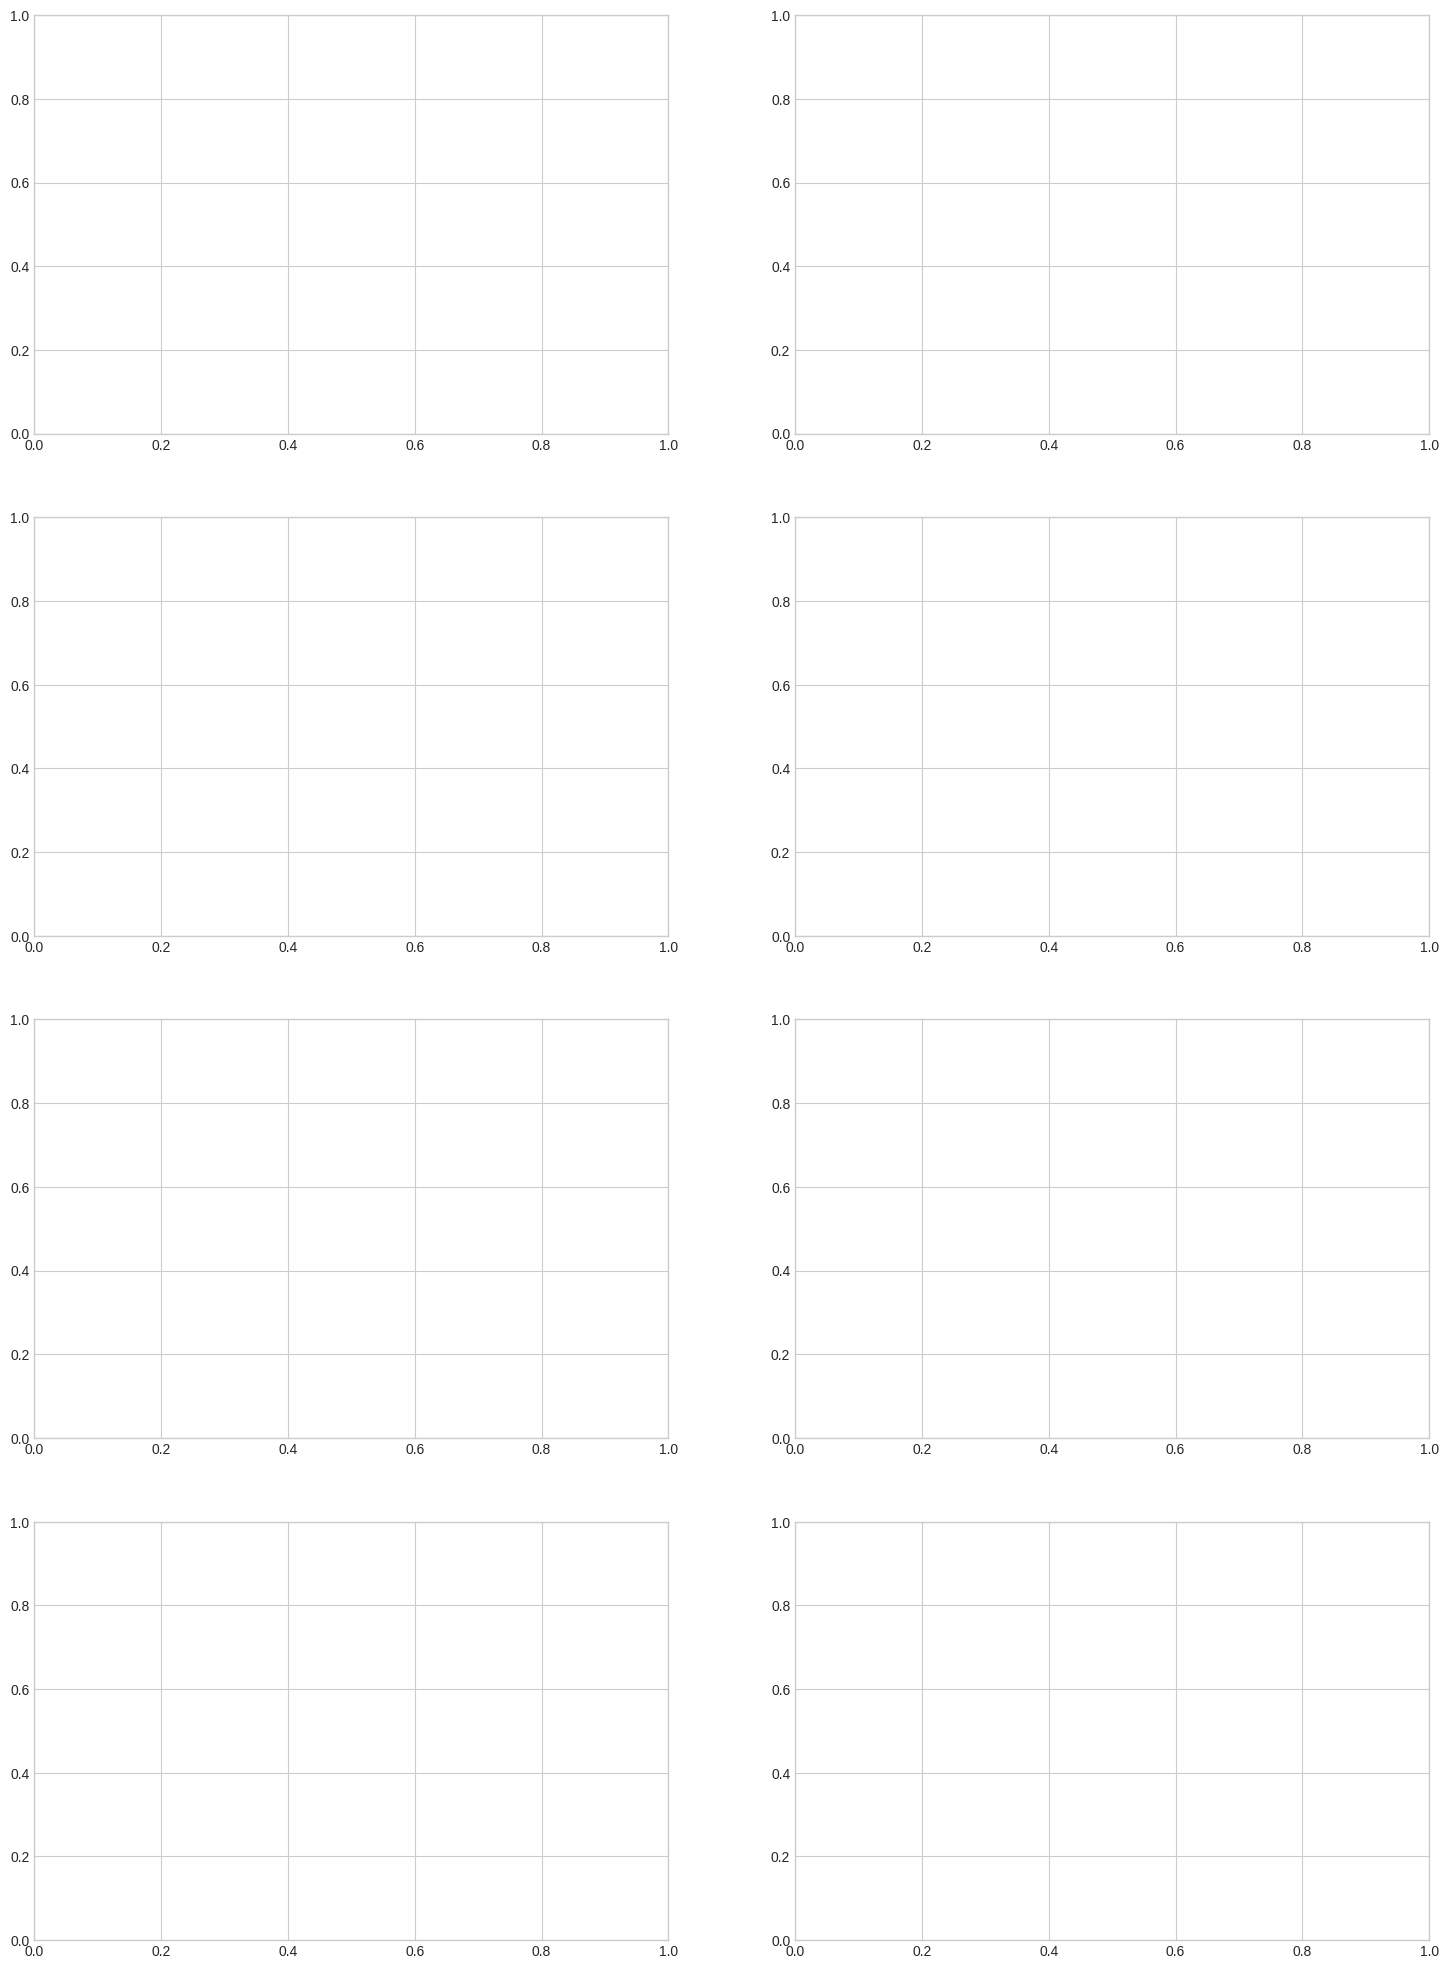

In [16]:

entries_orig = np.array(entries_orig)
#metrics = [rankcorr, precision, rel_err, ndcg_bin, ndcg, roc_auc, nrmse, apbin, apk, spectrum_laplacian_ksdist]
p_values = {}
for i in range(entries_orig.shape[0]):
    metric = int(entries_orig[i][2])
    pvalue = entries_orig[i][-1]
    #key = metric_names[metrics[metric]]
    key = str(metrics[metric])+str(metric)
    if not(key in p_values):
        p_values[key] = []
    p_values[key].append(pvalue)


r = np.array(p_values[str(metrics[metric])+str(metric)])
#print(r)
print(len(r[r<0.05])/len(r))
mpl.rcdefaults() 
plt.style.use('seaborn-whitegrid')
i = 0
f, axlist = plt.subplots(4, 2, figsize = (18,25))
print([(i,metrics[i]) for i in range(len(metrics))])
ordered_metrics = [4,6,3,5,0,1,2]
for m in ordered_metrics:
    metric = list(p_values.keys())[m]
    r = np.array(p_values[metric])
    #f, ax = plt.subplots(1, 2, figsize = (13,5))
    #p1 = sns.kdeplot(r, shade=True, color="r", kernel='cos', gridsize = 200, clip=(0,1.00001), ax=ax[0])
    #p1.axvline(x=0.05,c='k',linestyle='--')
    #p1.set_xlim(0.,1.0)
    #p1.set_ylim(0, 11)
    #p1.set_title(metric_names[metrics[i]])
    
    #ax[1].hist(r,bins=np.arange(0,1.0001,0.01), rwidth = 1)
    ax = axlist[i//2][i%2]
    
    ax.hist(r,bins=np.arange(0,1.0001,0.01), rwidth = 1, color='C0',alpha=0.8,edgecolor='k', linewidth=0.05,linestyle='-')
    ax.axvline(x=0.05,c='k',linestyle='--',alpha=0.45, color = 'grey')
    ax.set_xticks([i*0.2 for i in range(6)]+[0.05])

    ax.set_ylim(0,830)
    pless5 = len(r[r<0.05])/len(r)
    ax.text(s="%.1f"%(pless5*100)+"%",x=-0.037,y=770,fontsize=15,weight='semibold')
    ax.text(s="%.1f"%(100- pless5*100)+"%",x=0.5,y=770,fontsize=15,weight='semibold')
    ax.set_ylabel(metric_names[metrics[m]],fontsize=16,weight='semibold')    
    #print(metric,"Mean:",np.mean(r),", Median:",np.median(r), ", % under 5:",len(r[r<0.05])/len(r))
    i += 1
plt.subplots_adjust(wspace=0.08, hspace=0.07)
axlist[-1][-1].axis('off')
plt.savefig("hist_metrics", bbox_inches = 'tight', pad_inches = 0)
plt.show()

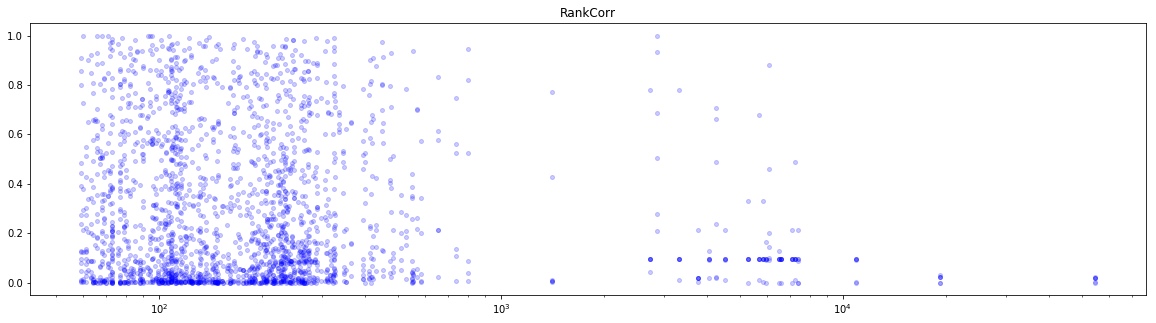

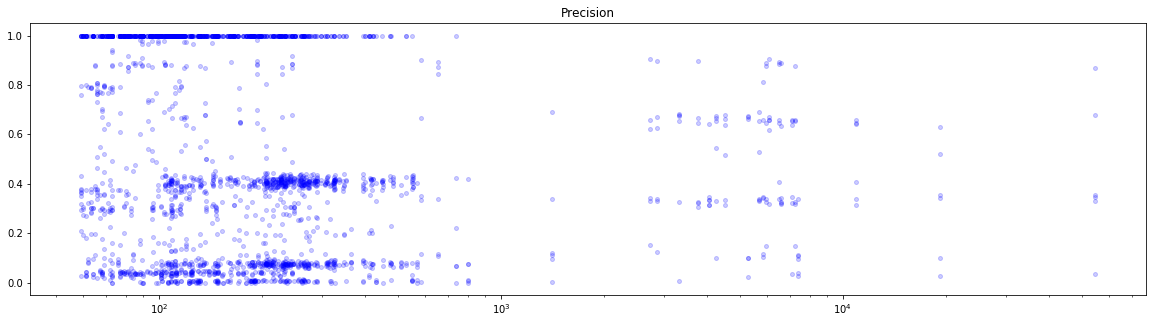

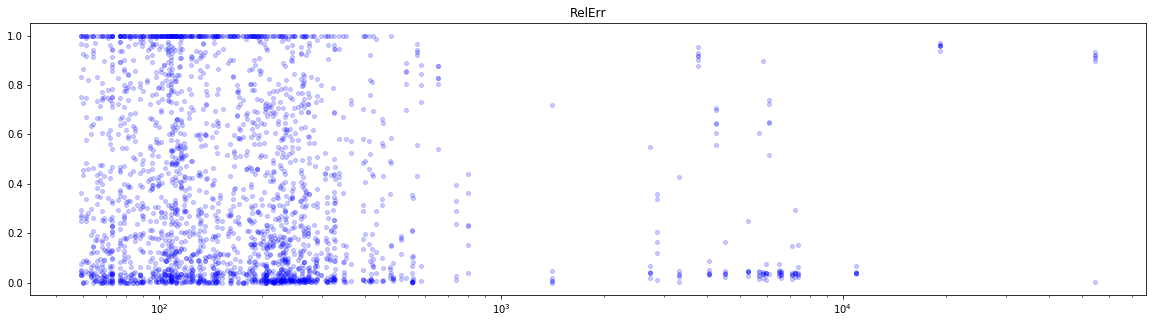

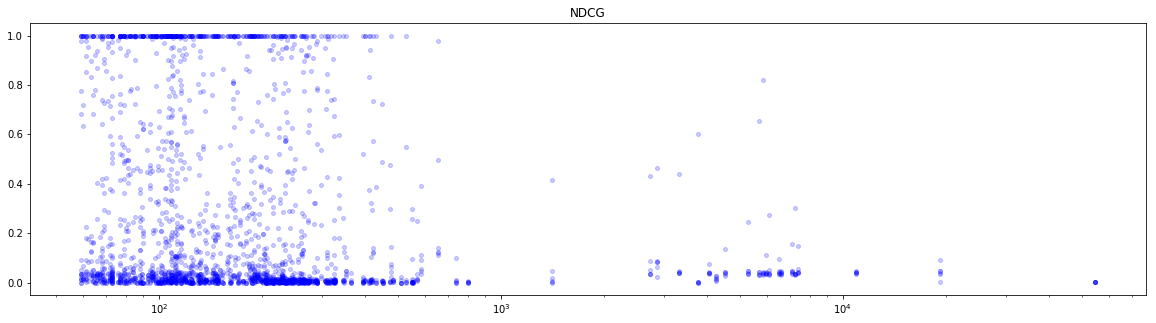

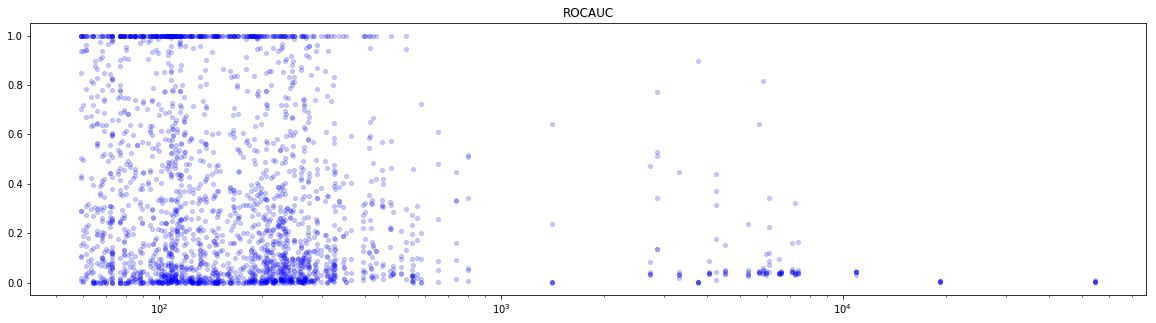

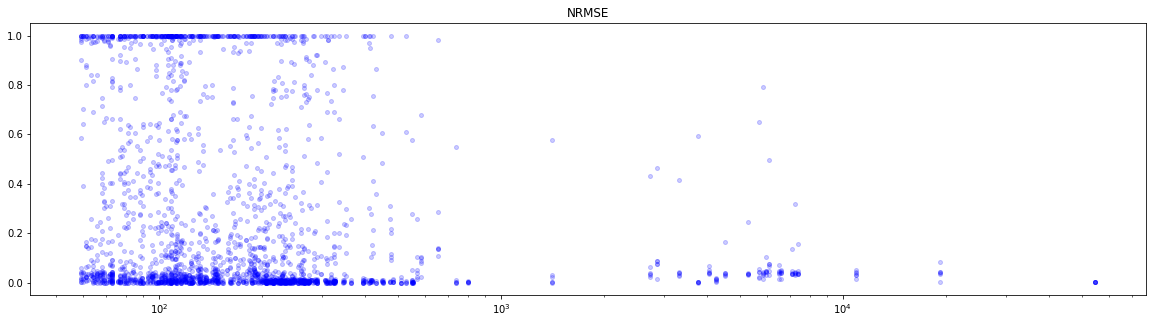

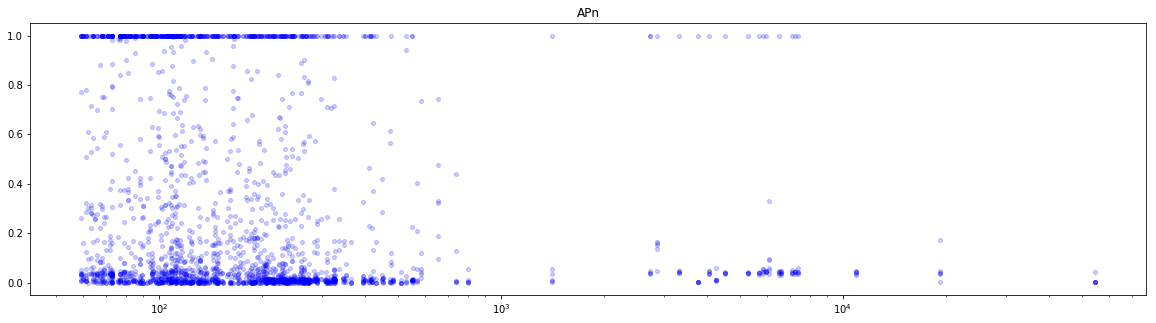

In [11]:
past_dataset = 0
pvalues_per_file = {}
i = 0
past_row = np.ones(3)*-1
for i in range(entries_orig.shape[0]):
    metric = int(entries_orig[i][2])
 
    dataset = int(entries_orig[i][0])
    pvalue = entries_orig[i][-1]
    key = metric_names[metrics[metric]]
    
    if np.any(entries_orig[i][:-1] != past_row):
        user_idx = 0
        
        if entries_orig[i][0] != past_row[0]:
            file = file_list[dataset]
            timestamps, groundTruth = read_timestamps_groundtruth(datapath[file][0],datapath[file][1])
    
    num_events = len(timestamps[user_idx])
    
    if not(key in pvalues_per_file):
        pvalues_per_file[key] = []
    pvalues_per_file[key].append((num_events, pvalue))
    
    past_row = entries_orig[i][:-1]
    user_idx += 1

for metric in pvalues_per_file:
    plt.figure(figsize = (20,5))
    x = [t[0] for t in pvalues_per_file[metric]]
    y = [t[1] for t in pvalues_per_file[metric]]
    plt.plot(x,y,'bo',alpha=0.2, markersize = 4)
    plt.xscale('log')
    plt.title(metric)
    plt.show()
    

In [96]:
entries = np.copy(entries_orig)
entries.shape
entries[:,3] = entries[:,3]<0.05
print(entries_orig)
print(entries)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 6.25532920e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.80294250e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.65697628e-01]
 ...
 [7.00000000e+00 4.00000000e+00 2.00000000e+00 5.46000000e-01]
 [7.00000000e+00 4.00000000e+00 2.00000000e+00 1.00000000e+00]
 [7.00000000e+00 4.00000000e+00 2.00000000e+00 3.30000000e-01]]
[[0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [7. 4. 2. 0.]
 [7. 4. 2. 0.]
 [7. 4. 2. 0.]]


In [9]:
x = pd.DataFrame(entries)
x.columns = ['dataset','model','metric','pvalue']
for c in x.columns:
    x[c] = x[c].astype('category')
x = pd.get_dummies(x, drop_first = True)
Y = x.iloc[:,-1]
del x['pvalue_1.0']


clf = LogisticRegression(random_state=0)
clf.fit(x, Y)

i = 0
for c in x.columns:
    if i>=0 and i<6:
        print(c, file_list[i+1], clf.coef_[0][i])
    elif i<10:
        print(c, models[i+1-6], clf.coef_[0][i])
    else:
        print(c, metric_names[metrics[i+1-10]], clf.coef_[0][i])
    i+=1

print(clf.intercept_)

dataset_1.0 CollegeMsg -1.9254310826980783
dataset_2.0 sx-askubuntu -0.9173171502581338
dataset_3.0 sx-mathoverflow -1.0087474222402444
dataset_4.0 sx-superuser -1.1748608557287856
dataset_5.0 email-Eu-core-temporal -1.2069900006892134
dataset_6.0 wiki-talk-temporal -0.17496039040336311
dataset_7.0 ADM4 -2.570944879210744
model_1.0 SG -1.4560388979069068
model_2.0 Cumulant -0.7558353749725086
model_3.0 Granger -0.5206155995568097
model_4.0 Precision -0.9485316165968122
metric_1.0 RelErr -0.970932220453862
metric_2.0 NDCGbin 0.2135587384616837
metric_3.0 NDCG 0.6437102437727504
metric_4.0 ROCAUC 1.6550988457553364
metric_5.0 NRMSE 0.2251098043549298
metric_6.0 APbin 1.517764926115271
metric_7.0 APn 0.5938198260012154
metric_8.0 Laplacian_Spec 1.47716277146432


/home/guilhermeborges/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


IndexError: list index out of range

In [10]:
x = pd.DataFrame(entries)
x.columns = ['dataset','model','metric','pvalue']
for c in x.columns:
    x[c] = x[c].astype('category')
x = pd.get_dummies(x, drop_first = False)

Y = x.iloc[:,-1]
del x['pvalue_0.0'], x['pvalue_1.0']

clf = LogisticRegression(random_state=0, fit_intercept=0)
clf.fit(x, Y)

print(metrics)
i = 0
for c in x.columns:
    if i>=0 and i<7:
        print(c, file_list[i], clf.coef_[0][i])
    elif i<12:
        print(c, models[i-7], clf.coef_[0][i])
    else:
        print(c, metric_names[metrics[i-12]], clf.coef_[0][i])
    i+=1

print(clf.intercept_)

[<function rankcorr at 0x7f3235efea60>, <function precision at 0x7f3235efeae8>, <function rel_err at 0x7f3235efe9d8>, <function ndcg_bin at 0x7f3235efebf8>, <function ndcg at 0x7f3235efec80>, <function roc_auc at 0x7f3235efed08>, <function nrmse at 0x7f3235efed90>, <function apbin at 0x7f3235efee18>, <function apk at 0x7f3235efeea0>, <function spectrum_laplacian_ksdist at 0x7f3235efef28>]
dataset_0.0 memetracker_2009-01 0.9845165908668387
dataset_1.0 CollegeMsg -0.9818829476691777
dataset_2.0 sx-askubuntu 0.02480475656744134
dataset_3.0 sx-mathoverflow -0.06660073457830497
dataset_4.0 sx-superuser -0.23256029662006683
dataset_5.0 email-Eu-core-temporal -0.26230011186524566
dataset_6.0 wiki-talk-temporal 0.7710931372017992
dataset_7.0 HkEM -1.646582863466421
model_0.0 ADM4 0.4610604591180155
model_1.0 SG -1.0044920949154608
model_2.0 Cumulant -0.3028725079183758
model_3.0 Granger -0.06723847309815528
model_4.0 RankCorr -0.4959698527539831
metric_0.0 Precision -0.8372576200900363
metric_

/home/guilhermeborges/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


IndexError: list index out of range

In [28]:
np.savetxt("entries_orig",entries_orig)
np.savetxt("entries",entries)

In [93]:
x = pd.DataFrame(entries)
x.columns = ['dataset','model','metric','pvalue']
for c in x.columns:
    x[c] = x[c].astype('category')
x = pd.get_dummies(x, drop_first = True)
Y = x.iloc[:,-1]

i = 0
for c in x.columns:
    if i>=0 and i<7:
        x.columns.values[i] = file_list[i+1]
        #print(c, file_list[i+1], clf.coef_[0][i])
    elif i<11:
        x.columns.values[i] = models[i+1-7]
        #print(c, models[i+1-6], clf.coef_[0][i])
    elif i<len(x.columns)-1:
        x.columns.values[i] = metric_names[metrics[i-10]]
        #print(c, metric_names[metrics[i+1-10]], clf.coef_[0][i])
    i+=1
x.columns.values[i-1] = "p_value"
print(x.iloc[1])
#np.savetxt("entries_processed",x)
x.to_csv("entries_processed", index=False)

sx-askubuntu              0
sx-mathoverflow           0
sx-superuser              0
email-Eu-core-temporal    0
wiki-talk-temporal        0
memetracker_2009-01       0
chalearn                  0
ADM4                      0
SG                        0
Cumulant                  0
Granger                   0
Precision                 0
RelErr                    0
NDCGbin                   0
NDCG                      0
ROCAUC                    0
NRMSE                     0
APbin                     0
APn                       0
Laplacian_Spec            0
p_value                   0
Name: 1, dtype: uint8


In [86]:
metrics

[<function __main__.rankcorr(A_true, A_pred, pvalues=False)>,
 <function __main__.precision(A_true, A_pred, k=10)>,
 <function __main__.rel_err(A_true, A_pred)>,
 <function __main__.ndcg_bin(A_true, A_pred)>,
 <function __main__.ndcg(A_true, A_pred)>,
 <function __main__.roc_auc(A_true, A_pred)>,
 <function __main__.nrmse(A_true, A_pred)>,
 <function __main__.apbin(A_true, A_pred)>,
 <function __main__.apk(A_true, A_pred)>,
 <function __main__.spectrum_laplacian_ksdist(A_true, A_pred, low=True)>]